# MLE and MAP Estimation

In this short tutorial we review how to do Maximum Likelihood (MLE) and Maximum a Posteriori (MAP) estimation in Pyro.

In [22]:
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import matplotlib.pyplot as plt
%matplotlib inline

We consider the simple "fair coin" example covered in a [previous tutorial](http://pyro.ai/examples/svi_part_i.html#A-simple-example).

In [23]:
data = torch.zeros(10)
data[0:6] = 1.0

def original_model(data):
    f = pyro.sample("latent_fairness", dist.Beta(10.0, 10.0))
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Bernoulli(f), obs=data)

To facilitate comparison between different inference techniques, we construct a training helper:

In [24]:
def train(model, guide, lr=0.005, n_steps=201):
    pyro.clear_param_store()
    adam_params = {"lr": lr}
    adam = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for step in range(n_steps):
        loss = svi.step(data)
        if step % 50 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

## MLE

Our model has a single latent variable `latent_fairness`. To do Maximum Likelihood Estimation we simply "demote" our latent variable `latent_fairness` to a Pyro parameter.

In [25]:
def model_mle(data):
    # note that we need to include the interval constraint; 
    # in original_model() this constraint appears implicitly in 
    # the support of the Beta distribution.
    f = pyro.param("latent_fairness", torch.tensor(0.5), 
                   constraint=constraints.unit_interval)
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Bernoulli(f), obs=data)

We can render our model as shown below.

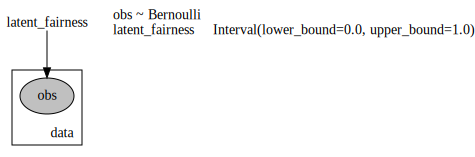

In [26]:
pyro.render_model(model_mle, model_args=(data,), render_distributions=True, render_params=True)

Since we no longer have any latent variables, our guide can be empty:

In [27]:
def guide_mle(data):
    pass

Let's see what result we get.

In [28]:
train(model_mle, guide_mle)

[iter 0]  loss: 6.9315
[iter 50]  loss: 6.7693
[iter 100]  loss: 6.7333
[iter 150]  loss: 6.7302
[iter 200]  loss: 6.7301


In [29]:
mle_estimate = pyro.param("latent_fairness").item()
print("Our MLE estimate of the latent fairness is {:.3f}".format(mle_estimate))

Our MLE estimate of the latent fairness is 0.600


We can also compare our MLE estimate with the analytical MLE estimate which is given as: $\frac{\#Heads}{\#Heads + \#Tails}$. As we encode `Heads` as 1 and `Tails` as 0, we can directly find the analytical MLE as `data.sum()/data.size(0)` or `data.mean()`.

In [30]:
print("The analytical MLE estimate of the latent fairness is {:.3f}".format(
      data.mean()))

The analytical MLE estimate of the latent fairness is 0.600


Thus with MLE we get a point estimate of `latent_fairness` which matches the analytical MLE estimate.

You may be wondering how to interpret the loss numbers in our experiment above. The loss is equivalent to the negative log likelihood (NLL) of observing the data under the Bernoulli likelihood. Thus, the above procedure was equivalent to minimizing the NLL. We confirm the same below.

In [31]:
nll = -dist.Bernoulli(mle_estimate).log_prob(data).sum()
print(f"The negative log likelihood given latent fairness = {mle_estimate:0.3f} is {nll:0.4f} which matches the loss obtained via our training procedure.")

The negative log likelihood given latent fairness = 0.600 is 6.7301 which matches the loss obtained via our training procedure.


## MAP

With Maximum a Posteriori estimation, we also get a point estimate of our latent variables. The difference to MLE is that these estimates will be regularized by the prior. We can understand the difference between the model we use for MLE and MAP via the rendering below, where we can see `latent_fairness` is a `pyro.sample` in original model.

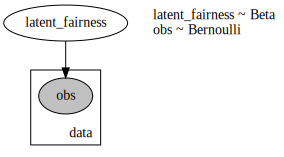

In [32]:
pyro.render_model(original_model, model_args=(data,), render_distributions=True)

To do MAP in Pyro we use a [Delta distribution](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.Delta) for the guide. Recall that the `Delta` distribution puts all its probability mass at a single value. The `Delta` distribution will be parameterized by a learnable parameter. 

In [33]:
def guide_map(data):
    f_map = pyro.param("f_map", torch.tensor(0.5),
                       constraint=constraints.unit_interval)
    pyro.sample("latent_fairness", dist.Delta(f_map))

Let's see how this result differs from MLE.

In [34]:
train(original_model, guide_map)

[iter 0]  loss: 5.6719
[iter 50]  loss: 5.6007
[iter 100]  loss: 5.6004
[iter 150]  loss: 5.6004
[iter 200]  loss: 5.6004


In [35]:
map_estimate = pyro.param("f_map").item()
print("Our MAP estimate of the latent fairness is {:.3f}".format(map_estimate))

Our MAP estimate of the latent fairness is 0.536


To understand what's going on note that the prior mean of the `latent_fairness` in our model is 0.5, since that is the mean of `Beta(10.0, 10.0)`. The MLE estimate (which ignores the prior) gives us a result that is entirely determined by the raw counts (6 heads and 4 tails). In contrast the MAP estimate is regularized towards the prior mean, which is why the MAP estimate is somewhere between 0.5 and 0.6. We can also understand these from the plot below. Infact, we can also analytically calculate the MAP estimate given the `Beta` prior and `Bernoulli` likelihood.

Our `Beta` prior is parameterised by $\alpha_{Heads}$ (= 10 in our example)  and $\alpha_{Tails}$ (= 10 in our example). The closed form expression for MAP estimate is:
$\frac{\alpha_{Heads} + ~\#Heads}{\alpha_{Heads} + ~\#Heads +~ \alpha_{Tails} + ~\#Tails}$ = $\frac{10 + 6}{10 + 6 + 10 + 4}$ = $\frac{16}{30} = 0.5\bar{3}$

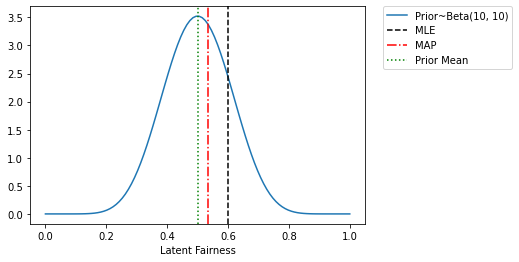

In [36]:
x = torch.linspace(0.0, 1.0, 100)
plt.plot(x, dist.Beta(10, 10).log_prob(x).exp(), label='Prior~Beta(10, 10)')
plt.xlabel("Latent Fairness")
plt.axvline(mle_estimate, color='k', linestyle='--', label='MLE')
plt.axvline(map_estimate, color='r', linestyle='-.', label='MAP')
plt.axvline(0.5, color='g', linestyle=':', label='Prior Mean')
plt.legend(bbox_to_anchor=(1.44,1), borderaxespad=0)

# Doing the same thing with AutoGuides

In the above we defined guides by hand. 
It's often much easier to rely on Pyro's [AutoGuide machinery](https://docs.pyro.ai/en/stable/infer.autoguide.html?highlight=autoguide). 
Let's see how we can do MLE and MAP inference using AutoGuides.

To do MLE estimation we first use [`mask(False)`](https://docs.pyro.ai/en/stable/poutine.html?highlight=mask#pyro.poutine.handlers.mask) to instruct Pyro to ignore the `log_prob` of the latent variable `latent_fairness` in the model. 
(Note we need to do this for every latent variable.)
This way the only non-zero `log_prob` in the model will be from the Bernoulli likelihood and ELBO maximization will be equivalent to likelihood maximization.

In [37]:
def masked_model(data):
    f = pyro.sample("latent_fairness", 
                    dist.Beta(10.0, 10.0).mask(False))
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Bernoulli(f), obs=data)

Next we define an [`AutoDelta`](https://docs.pyro.ai/en/stable/infer.autoguide.html?highlight=autodelta#autodelta) guide, which learns a point estimate for each latent variable (i.e. we do not learn any uncertainty):

In [38]:
autoguide_mle = pyro.infer.autoguide.AutoDelta(masked_model)
train(masked_model, autoguide_mle)
print("Our MLE estimate of the latent fairness is {:.3f}".format(
      autoguide_mle.median(data)["latent_fairness"].item()))

[iter 0]  loss: 7.0436
[iter 50]  loss: 6.8213
[iter 100]  loss: 6.7467
[iter 150]  loss: 6.7319
[iter 200]  loss: 6.7302
Our MLE estimate of the latent fairness is 0.598


To do MAP inference we again use an `AutoDelta` guide but this time on the original model in which `latent_fairness` is a latent variable:

In [39]:
autoguide_map = pyro.infer.autoguide.AutoDelta(original_model)
train(original_model, autoguide_map)
print("Our MAP estimate of the latent fairness is {:.3f}".format(
      autoguide_map.median(data)["latent_fairness"].item()))

[iter 0]  loss: 5.6889
[iter 50]  loss: 5.6005
[iter 100]  loss: 5.6004
[iter 150]  loss: 5.6004
[iter 200]  loss: 5.6004
Our MAP estimate of the latent fairness is 0.536


We can also quickly verify that had we chosen a uniform prior in our original model, our MAP estimate would be the same as the MLE estimate.

In [40]:
def original_model_uniform_prior(data):
    f = pyro.sample("latent_fairness", dist.Uniform(low=0.0, high=1.0))
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Bernoulli(f), obs=data)

In [41]:
autoguide_map_uniform_prior = pyro.infer.autoguide.AutoDelta(original_model_uniform_prior)
train(original_model_uniform_prior, autoguide_map_uniform_prior)
print("Our MAP estimate of the latent fairness under the Uniform prior is {:.3f} matching the MLE estimate".format(
      autoguide_map_uniform_prior.median(data)["latent_fairness"].item()))

[iter 0]  loss: 6.7490
[iter 50]  loss: 6.7302
[iter 100]  loss: 6.7301
[iter 150]  loss: 6.7301
[iter 200]  loss: 6.7301
Our MAP estimate of the latent fairness under the Uniform prior is 0.600 matching the MLE estimate
